In [1]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils
from const import *

### GPU Setup

In [2]:
# Specific GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[2:4], 'GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
mirro_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


### Data Preprocessing

In [3]:
# Find the most recent file in injec_curve
# datas = utils.retur_most_recen(f'{xom_data_path}padde_cuts/')
datas = 'padde_cuts-34745-2850-6998.pkl'
print(f'Most recent file: {datas}')

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

Most recent file: padde_cuts-34745-2850-6998.pkl


In [4]:
# Dataset composition setup
DETEC_TYPE = 'plane_moon_cut_injec'
NUMBE_RELEV = 2000
NUMBE_IRREL = 2000

In [5]:
# Separate full dataset into relevant and irrelevant components
full_relev_index = []
for i in range(len(raw_x_data)):
    if raw_x_data[i, -1, 1][DETEC_TYPE]:
        full_relev_index.append(i)
        
# Take a random sample of a relevant
relev_index = random.sample(full_relev_index, NUMBE_RELEV)
relev_curve = np.copy(raw_x_data[relev_index])
# Take a random sample of a irrelevant
irrel_curve = np.delete(raw_x_data, full_relev_index, axis=0)
irrel_curve = irrel_curve[utils.retur_rando_sampl(NUMBE_IRREL, len(irrel_curve))]

# Shuffle the order of the data
rando_shuff_x_data = np.concatenate((relev_curve, irrel_curve), axis=0)
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1][DETEC_TYPE]

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

50.00% of the dataset contains a full injection


In [6]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train_np = np.array(x_data[:split])
full_x_train = norma_full_x_data[:split]
x_test_np = np.array(x_data[split:stop])
full_x_test = norma_full_x_data[split:stop]
y_train_np = y_data[:split]
y_test_np = y_data[split:stop]

In [7]:
# Remove non-full batches (because they cause problems)
BATCH_SIZE = 100

# If no remainder, skip
if x_train_np.shape[0] % BATCH_SIZE:
    x_train_np = x_train_np[:-(x_train_np.shape[0] % BATCH_SIZE)]
    full_x_train = full_x_train[:-(full_x_train.shape[0] % BATCH_SIZE)]
    y_train_np = y_train_np[:-(y_train_np.shape[0] % BATCH_SIZE)]

if x_test_np.shape[0] % BATCH_SIZE:
    x_test_np = x_test_np[:-(x_test_np.shape[0] % BATCH_SIZE)]
    full_x_test = full_x_test[:-(full_x_test.shape[0] % BATCH_SIZE)]
    y_test_np = y_test_np[:-(y_test_np.shape[0] % BATCH_SIZE)]

In [8]:
# Convert to tensors
x_train = tf.convert_to_tensor(x_train_np)
x_test = tf.convert_to_tensor(x_test_np)
y_train = tf.convert_to_tensor(y_train_np)
y_test = tf.convert_to_tensor(y_test_np)

In [9]:
# Baseline calculations for email updates
# Baseline accuracy, precision, and recall are all the same
basel_value = sum(y_test_np) / len(y_test_np) 
if basel_value < 0.5:
    basel_value = 1 - basel_value

### Training

In [27]:
# Max number of epochs
EPOCH = 20
# Early stopping patience
PATIE = 4

In [28]:
# Callbacks

# tensorboard = TensorBoard(log_dir=f'{main_path}tensorboard/{datas}_{int(time.time())}')
early_stopp = EarlyStopping(monitor='val_accuracy', patience=PATIE)
resto_valid_accur = utils.resto_best_valid_accur()
email_train_progr = utils.email_train_progr()

callb = [resto_valid_accur, early_stopp, email_train_progr]#, tensorboard]

#### New Model

In [33]:
# Model

l2_norma_gradi = 0.25
with mirro_strat.scope():
    model = keras.Sequential()
    
    model.add(layers.Masking(mask_value=0.0,input_shape=(1900, 1)))
    
    model.add(
        layers.GRU(68,
                   activation='tanh',
                   return_sequences=True))
    model.add(layers.GRU(48, activation='tanh'))

    model.add(layers.Dense(40, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Nadam(learning_rate=3e-4)
    
    # Metrics
    metri = ['accuracy']#,precisionL, recallL, Precision(), Recall()]
    
    model.compile(loss='BinaryCrossentropy',
                  optimizer=opt,
                  metrics=metri)

In [59]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, 1900, 1)           0         
_________________________________________________________________
gru_20 (GRU)                 (None, 1900, 68)          14484     
_________________________________________________________________
gru_21 (GRU)                 (None, 48)                16992     
_________________________________________________________________
dense_30 (Dense)             (None, 40)                1960      
_________________________________________________________________
dropout_20 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                656       
_________________________________________________________________
dropout_21 (Dropout)         (None, 16)              

In [60]:
histo = model.fit(x_train,
                  y_train,
                  epochs=2,
                  batch_size=BATCH_SIZE,
                  callbacks=callb,
                  validation_data=(x_test, y_test))

Epoch 1/2
3/3 [==============================] - 8s 3s/step - recall_7: 0.9821 - accuracy: 0.3867 - recallL: 0.9828 - precision_7: 0.3767 - precisionL: 0.3767 - loss: 0.7024 - val_recall_7: 0.9545 - val_accuracy: 0.4400 - val_recallL: 0.9530 - val_precision_7: 0.4375 - val_precisionL: 0.4375 - val_loss: 0.6959
Epoch 2/2
3/3 [==============================] - 5s 2s/step - recall_7: 0.6607 - accuracy: 0.4633 - recallL: 0.6501 - precision_7: 0.3756 - precisionL: 0.3832 - loss: 0.6950 - val_recall_7: 0.0227 - val_accuracy: 0.5400 - val_recallL: 0.0192 - val_precision_7: 0.2500 - val_precisionL: 0.2500 - val_loss: 0.6924

Restoring model weights from the end of the best epoch (56.0%).


In [82]:
t = model.predict(x_train).squeeze()

In [81]:
def get_saliency_map(model, image, class_idx):
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)

        loss = predictions[:, class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    smap = gradient
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    
    return smap

In [ ]:
### DOUBLE CHECK IF PRECISION AND RECALL (MAINLY RECALL) CALCULATIONS ARE CORRECT

In [92]:
y_test

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.])>

In [83]:
a = get_saliency_map(model, x_train, 0)

In [65]:
a.shape

(300, 1900)

In [84]:
num=0

In [85]:
x_train[num]

<tf.Tensor: shape=(1900, 1), dtype=float64, numpy=
array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.15492968],
       [0.43963622],
       [0.37184931]])>

In [86]:
y_train[num]

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

In [91]:
max(t)

0.49406725

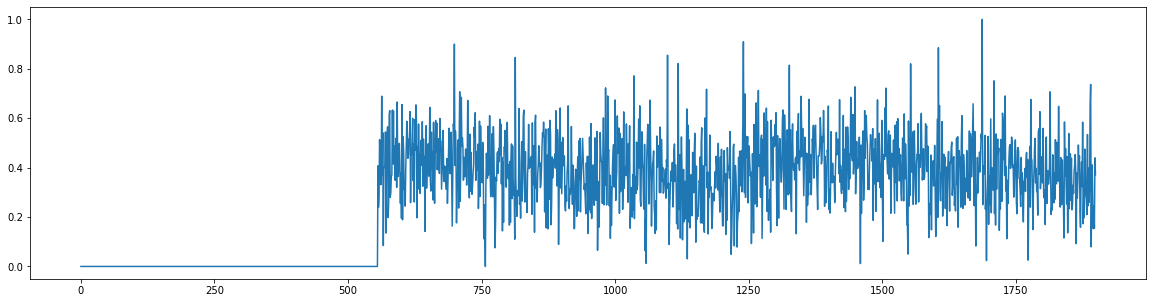

In [87]:
plt.figure(figsize=(20,5))
plt.plot(x_train[num])

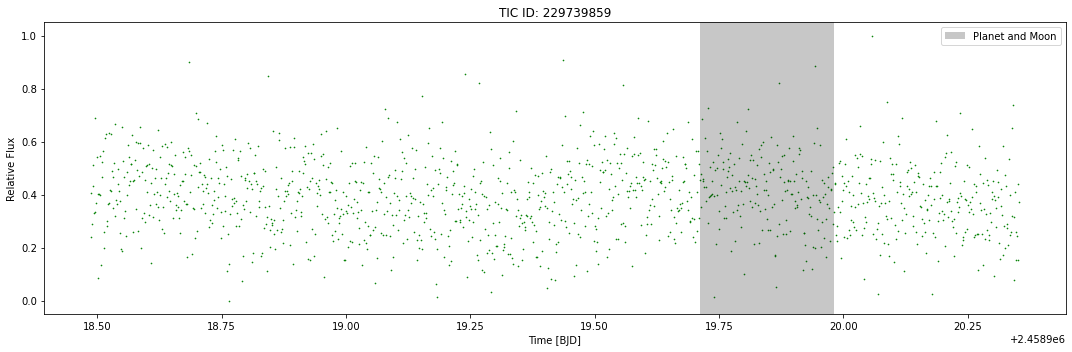

In [88]:
utils.show_curve(full_x_train, [num,num+1], highl_injec=1)

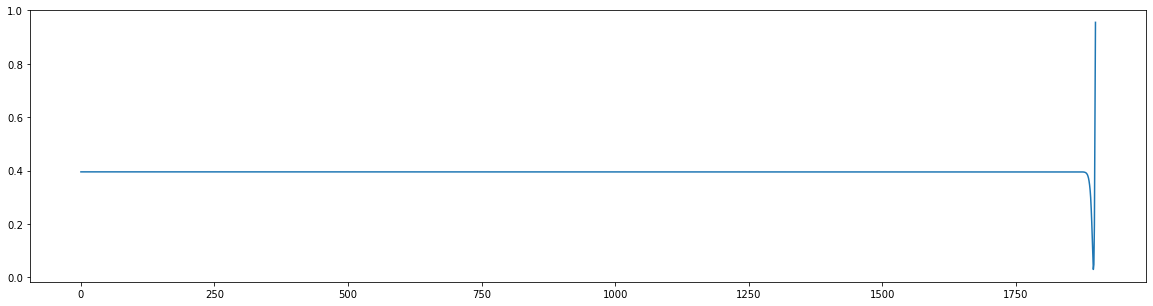

In [89]:
plt.figure(figsize=(20,5))
# print(np.where(a[num]<.99999)[0])
data = a[num][np.where(a[num]<.99999)]
# data = a[num]
plt.plot(data)

In [20]:
importlib.reload(utils)

<module 'utils' from '/home/rfradkin/xom/py_script/utils.py'>

In [14]:
x_train[0]

<tf.Tensor: shape=(1900, 1), dtype=float32, numpy=
array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.3456196 ],
       [0.4307573 ],
       [0.33911946]], dtype=float32)>

#### Continue Training

### Testing

In [10]:
# Set True if want to use the full dataset, not
# just the testing dataset
full_datas = True

# Specify start and stop if want to use a section
# of the data
start = 0
stop = None

if full_datas:
    x_full_predi_data = norma_full_x_data[start:stop]
    x_predi_data = x_data[start:stop]
    y_predi_data = y_data[start:stop]
else:
    x_full_predi_data = full_x_test[start:stop]
    x_predi_data = x_test[start:stop]
    y_predi_data = y_test_np[start:stop]

In [12]:
dependencies = {
    'precision': utils.preci,
    'recall':utils.recal
}

In [13]:
model_file = f'combi-padde_cuts-345235-30352-72662.pkl-0-1651107218.h5'
model = tf.keras.models.load_model(f'{xom_data_path}plane_moon_model/{model_file}',custom_objects=dependencies);

In [14]:
# Make predictions
predi = model.predict(x_predi_data).squeeze()

In [25]:
cutof = 0.505

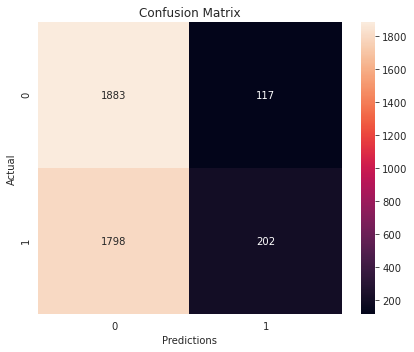

In [26]:
utils.show_confu_matri(x_full_predi_data, predi, cutof)#, 'stell_radiu', 5)

In [19]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

In [21]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

In [22]:
# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

In [ ]:
utils.show_featu_preci_recal(x_full_predi_data,
                       predi,
                       y_predi_data,
                       cutof,
                       featu='moon_radiu',
                       bins=25,
                       equal_width_bins=True,
                       stand_axis=True)
# Possible third axis with AUC
# AUC in red overplotted

In [ ]:
importlib.reload(utils)

In [ ]:
# can you have a false positive rate as a function of moon radius??

In [ ]:
utils.show_preci_recal(predi, y_predi_data, cutof)

In [ ]:
utils.show_roc(predi, y_predi_data, cutof)

In [ ]:
utils.show_histo(norma_full_x_data, 'moon_radiu')

#### Formatting